# Churn operadora Machine Learning (Python)

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import requests
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

import re

# IQR/Z score.
from scipy.stats import stats

# Seleción de variables.
from sklearn.feature_selection import SelectKBest

# Modelos Selección.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Modelos.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold

# Preprocesado.
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
import pickle
# Métricas.
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report

## Cargar los datasets y construir un único tablón analítico con todas las variables

In [2]:
dic_clientes = pd.read_csv("clientes_diciembre.csv", sep = "|", parse_dates = ["antiguedad"])
dic_consumos = pd.read_csv("consumos_diciembre.csv", sep = "|")
dic_fin = pd.read_csv("financiacion_diciembre.csv", sep = "|")
dic_prod = pd.read_csv("productos_diciembre.csv", sep = "|")

In [3]:
print('Tamaño de tabla de consumos diciembre:',dic_consumos.shape[0])
print('Tamaño de tabla de clientes diciembre:',dic_clientes.shape[0])
print('Tamaño de tabla de financiación diciembre:',dic_fin.shape[0])
print('Tamaño de tabla de productos diciembre:',dic_prod.shape[0])

Tamaño de tabla de consumos diciembre: 95467
Tamaño de tabla de clientes diciembre: 95467
Tamaño de tabla de financiación diciembre: 24198
Tamaño de tabla de productos diciembre: 95467


In [4]:
print('Clientes en tabla financiacion\n', dic_clientes['id'].isin(dic_fin['id']).value_counts())
print('Clientes en tabla consumos\n',dic_clientes['id'].isin(dic_consumos['id']).value_counts())
print('Clientes en tabla productos\n',dic_clientes['id'].isin(dic_prod['id']).value_counts())

Clientes en tabla financiacion
 False    71269
True     24198
Name: id, dtype: int64
Clientes en tabla consumos
 True    95467
Name: id, dtype: int64
Clientes en tabla productos
 True    95467
Name: id, dtype: int64


In [5]:
dic_cl_con = pd.merge(dic_clientes, dic_consumos, on = "id", how = "left")
dic_cl_con_f = pd.merge(dic_cl_con, dic_fin, on= "id", how = "left")
dic_full = pd.merge(dic_cl_con_f, dic_prod, on = "id", how = "left")

In [6]:
dic_full.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,TV
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,NaN,NaN,110,79,10897,12806,13751,NaN,NaN,NaN,FIBRA,50MB,tv-futbol
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,NaN,NaN,189,89,18657,6499,10862,NaN,NaN,SI,FIBRA,600MB,tv-futbol
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,NaN,NaN,129,30,15511,17013,16743,NaN,NaN,SI,ADSL,35MB,tv-futbol
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,NaN,NaN,51,52,12670,3393,6771,NaN,NaN,NaN,FIBRA,200MB,tv-familiar
4,5,30,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NaN,183,3,23756,18436,4485,NaN,NaN,NaN,ADSL,10MB,tv-futbol


In [7]:
dic_full.shape

(95467, 19)

In [8]:
en_clientes = pd.read_csv("clientes_enero.csv", sep = "|", parse_dates = ["antiguedad"])
en_consumos = pd.read_csv("consumos_enero.csv", sep = "|")
en_fin = pd.read_csv("financiacion_enero.csv", sep = "|")
en_prod = pd.read_csv("productos_enero.csv", sep = "|")

In [9]:
print('Tamaño de tabla de consumos enero:',en_consumos.shape[0])
print('Tamaño de tabla de clientes enero:',en_clientes.shape[0])
print('Tamaño de tabla de financiación enero:',en_fin.shape[0])
print('Tamaño de tabla de productos enero:',en_prod.shape[0])

Tamaño de tabla de consumos enero: 92711
Tamaño de tabla de clientes enero: 92711
Tamaño de tabla de financiación enero: 25332
Tamaño de tabla de productos enero: 92711


In [10]:
print('Clientes en tabla financiacion\n', en_clientes['id'].isin(en_fin['id']).value_counts())
print('Clientes en tabla consumos\n',en_clientes['id'].isin(en_consumos['id']).value_counts())
print('Clientes en tabla productos\n',en_clientes['id'].isin(en_prod['id']).value_counts())

Clientes en tabla financiacion
 False    67379
True     25332
Name: id, dtype: int64
Clientes en tabla consumos
 True    92711
Name: id, dtype: int64
Clientes en tabla productos
 True    92711
Name: id, dtype: int64


In [11]:
en_cl_con = pd.merge(en_clientes, en_consumos, on = "id", how = "left")
en_cl_con_f = pd.merge(en_cl_con, en_fin, on = "id", how = "left")
en_full = pd.merge(en_cl_con_f, en_prod, on = "id", how = "left")

In [12]:
## Valores únicos
print('Enero: ',len(en_full['id'].unique()))
print('Diciembre: ',len(dic_full['id'].unique()))

Enero:  92711
Diciembre:  95467


In [13]:
dic_full["mes"] = "dic"
en_full["mes"] = "en"

   - Se observa que en enero hubo una disminución de 3000 clientes aproximadamente. Por tanto, la empresa perdió más clientes de los que ganó. 
        - __7085 clientes abandonaron la empresa.__

In [14]:
len(dic_full) - dic_full.id.isin(en_full.id).sum()

7085

   - Creación de la variable target. Se buscan los "id" de enero que coinciden con los de diciembre, asignando 0 si son idénticos o 1 si no lo son.

In [15]:
churn = pd.DataFrame()
churn['churn'] = np.where(dic_full.id.isin(en_full.id) == True, 0, 1)
churn['id'] =dic_full['id'] 

In [16]:
####  Antes de concatenar las cosechas, voy a transformar la variable antigüedad
dic_full['duracion'] = (datetime(2019,12,31) - dic_full["antiguedad"])
en_full['duracion'] = (datetime(2020,1,31) - en_full["antiguedad"])

In [17]:
## Concatenamos las dos cosechas y normalizamos todas las variables

data = pd.concat([dic_full, en_full], sort = False, ignore_index=True)
data.columns= data.columns.str.lower()
data.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,...,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos,conexion,vel_conexion,tv,mes,duracion
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,NaN,NaN,110,79,...,12806,13751,NaN,NaN,NaN,FIBRA,50MB,tv-futbol,dic,402 days 15:12:00
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,NaN,NaN,189,89,...,6499,10862,NaN,NaN,SI,FIBRA,600MB,tv-futbol,dic,860 days 20:41:00
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,NaN,NaN,129,30,...,17013,16743,NaN,NaN,SI,ADSL,35MB,tv-futbol,dic,6577 days 10:10:00
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,NaN,NaN,51,52,...,3393,6771,NaN,NaN,NaN,FIBRA,200MB,tv-familiar,dic,1605 days 13:07:00
4,5,30,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NaN,183,3,...,18436,4485,NaN,NaN,NaN,ADSL,10MB,tv-futbol,dic,8158 days 21:41:00


In [18]:
data.columns

Index(['id', 'edad', 'facturacion', 'antiguedad', 'provincia', 'num_lineas',
       'num_dt', 'incidencia', 'num_llamad_ent', 'num_llamad_sal', 'mb_datos',
       'seg_llamad_ent', 'seg_llamad_sal', 'financiacion', 'imp_financ',
       'descuentos', 'conexion', 'vel_conexion', 'tv', 'mes', 'duracion'],
      dtype='object')

In [19]:
# Transformación de la variable antigüedad a días, horas... Esta parte podría hacerse en la parte de FE
data["duracion"] = data.duracion.apply(lambda x: int(x.days))

# Month:
data["month"] = data.antiguedad.apply(lambda x: x.strftime("%B"))

# Lo mismo con día de la semana. 
data["dia"] = data.antiguedad.apply(lambda x: x.strftime("%A"))

# Recoger la info de la hora.
data["hora"] = data.antiguedad.apply(lambda x: int(x.hour))

# Categórica para poder tener interpretabilidad.
data["hora_bin"] = pd.cut(data["hora"], bins = [-1,6,12,18,23], labels = ["Madrugada", "Mañana", "Tarde", "Noche"])

# Se elimina la variable original pues ya está convertida a numérica.
data.drop(columns = "antiguedad", inplace = True)

# Pre procesado y  limpieza de los datos



In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188178 entries, 0 to 188177
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   id              188178 non-null  int64   
 1   edad            188178 non-null  int64   
 2   facturacion     188178 non-null  float64 
 3   provincia       188178 non-null  object  
 4   num_lineas      188178 non-null  int64   
 5   num_dt          7343 non-null    float64 
 6   incidencia      5565 non-null    object  
 7   num_llamad_ent  188178 non-null  int64   
 8   num_llamad_sal  188178 non-null  int64   
 9   mb_datos        188178 non-null  int64   
 10  seg_llamad_ent  188178 non-null  int64   
 11  seg_llamad_sal  188178 non-null  int64   
 12  financiacion    13038 non-null   object  
 13  imp_financ      13038 non-null   float64 
 14  descuentos      39192 non-null   object  
 15  conexion        188176 non-null  object  
 16  vel_conexion    188172 non-null  objec

In [21]:
cat_cols= data.select_dtypes(include=['object','category']).columns
num_cols = data.select_dtypes(exclude=['object','category']).columns

In [22]:
data[cat_cols].describe()

,provincia,incidencia,financiacion,descuentos,conexion,vel_conexion,tv,mes,month,dia,hora_bin
count,188178,5565,13038,39192,188176,188172,188178,188178,188178,188178,188178
unique,50,1,1,1,2,14,3,2,12,7,4
top,Zaragoza,SI,SI,SI,ADSL,200MB,tv-futbol,dic,January,Wednesday,Madrugada
freq,3918,5565,13038,39192,95220,19017,95825,95467,19953,27212,54984


In [23]:
data[num_cols].describe()

,id,edad,facturacion,num_lineas,num_dt,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,imp_financ,duracion,hora
count,188178.000000,188178.000000,188178.000000,188178.000000,7343.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,13038.000000,188178.000000,188178.000000
mean,49995.915575,50.592227,207.440105,3.559731,2.515729,124.960580,49.942060,12499.843850,9964.973217,9979.341969,22.270750,4483.265918,11.500276
std,28868.075573,19.728833,111.291972,1.090756,1.122437,72.457194,29.163648,7228.701809,5779.620186,5803.444024,10.169251,2687.133125,6.927324
min,1.000000,18.000000,15.000439,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.009999,-1.000000,0.000000
25%,24980.000000,33.000000,111.370882,3.000000,2.000000,62.000000,25.000000,6205.000000,4956.000000,4959.000000,13.444882,2158.000000,6.000000
50%,49985.000000,50.000000,206.927616,4.000000,3.000000,125.000000,50.000000,12496.000000,9959.000000,9980.000000,21.883685,4491.000000,12.000000
75%,75005.750000,68.000000,304.388724,4.000000,4.000000,188.000000,75.000000,18764.000000,14965.000000,14998.000000,31.134052,6807.000000,18.000000
max,100000.000000,85.000000,399.998433,39.000000,4.000000,250.000000,100.000000,25000.000000,20000.000000,20000.000000,39.991954,9160.000000,23.000000


##  Tratamiento de nulos

In [24]:
data.isnull().sum()

id                     0
edad                   0
facturacion            0
provincia              0
num_lineas             0
num_dt            180835
incidencia        182613
num_llamad_ent         0
num_llamad_sal         0
mb_datos               0
seg_llamad_ent         0
seg_llamad_sal         0
financiacion      175140
imp_financ        175140
descuentos        148986
conexion               2
vel_conexion           6
tv                     0
mes                    0
duracion               0
month                  0
dia                    0
hora                   0
hora_bin               0
dtype: int64

In [25]:
## Las variables incidencia, financiación, descuentos cuando están a nulo significa que es NO (0)

var_no = ['incidencia','financiacion','descuentos']

for i in var_no:
    data[i].fillna('NO',inplace=True)

In [26]:
## Las variables num_dt, imp_financ cuando están a nulo significa que es el valor es 0.
var_cero = ['num_dt','imp_financ']

for i in var_cero:
    data[i].fillna(0,inplace=True)

In [27]:
data.isnull().sum()

id                0
edad              0
facturacion       0
provincia         0
num_lineas        0
num_dt            0
incidencia        0
num_llamad_ent    0
num_llamad_sal    0
mb_datos          0
seg_llamad_ent    0
seg_llamad_sal    0
financiacion      0
imp_financ        0
descuentos        0
conexion          2
vel_conexion      6
tv                0
mes               0
duracion          0
month             0
dia               0
hora              0
hora_bin          0
dtype: int64

<AxesSubplot: >

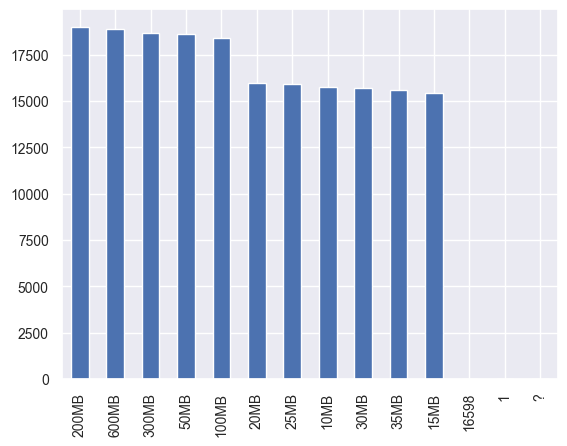

In [28]:
data['vel_conexion'].value_counts().plot(kind='bar')

In [29]:
data.dtypes

id                   int64
edad                 int64
facturacion        float64
provincia           object
num_lineas           int64
num_dt             float64
incidencia          object
num_llamad_ent       int64
num_llamad_sal       int64
mb_datos             int64
seg_llamad_ent       int64
seg_llamad_sal       int64
financiacion        object
imp_financ         float64
descuentos          object
conexion            object
vel_conexion        object
tv                  object
mes                 object
duracion             int64
month               object
dia                 object
hora                 int64
hora_bin          category
dtype: object

In [30]:
data[data['vel_conexion']=='?']

,id,edad,facturacion,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,...,descuentos,conexion,vel_conexion,tv,mes,duracion,month,dia,hora,hora_bin
70528,73889,69,118.515385,Castellón,2,0.0,NO,74,99,12169,...,NO,FIBRA,?,tv-familiar,dic,6108,April,Thursday,19,Noche


In [31]:
data[data['vel_conexion']=='1']

,id,edad,facturacion,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,...,descuentos,conexion,vel_conexion,tv,mes,duracion,month,dia,hora,hora_bin
70426,73779,26,209.565464,Pontevedra,5,1.0,NO,82,29,9667,...,NO,ADSL,1,tv-futbol,dic,7422,September,Saturday,1,Madrugada


In [32]:
data[data['vel_conexion']=='16598']

,id,edad,facturacion,provincia,num_lineas,num_dt,incidencia,num_llamad_ent,num_llamad_sal,mb_datos,...,descuentos,conexion,vel_conexion,tv,mes,duracion,month,dia,hora,hora_bin
12,13,55,209.36555,Huelva,3,0.0,NO,118,13,18030,...,NO,FIBRA,16598,tv-familiar,dic,137,August,Thursday,23,Noche


In [33]:
adsl = data.query('conexion == "ADSL"')
adsl.groupby('vel_conexion')['conexion'].count().sort_values(ascending=False)

vel_conexion
20MB     15995
25MB     15952
10MB     15776
30MB     15708
35MB     15619
15MB     15436
300MB      164
600MB      158
50MB       145
200MB      136
100MB      127
1            1
Name: conexion, dtype: int64

In [34]:
# Vemos que dentro de las conexiones adsl, la velocidad de conexión más repetida es la de 20 MB 
data['vel_conexion'] = data['vel_conexion'].replace('1', '20MB')

In [35]:
fibra = data.query('conexion == "FIBRA"')
fibra.groupby('vel_conexion')['conexion'].count().sort_values(ascending=False)

vel_conexion
200MB    18881
600MB    18763
300MB    18508
50MB     18496
100MB    18303
16598        1
?            1
Name: conexion, dtype: int64

In [36]:
# Vemos que dentro de las conexiones fibra, la velocidad de conexión más repetida es la de 200 MB 
data['vel_conexion'] = data['vel_conexion'].replace('?', '200MB')
data['vel_conexion'] = data['vel_conexion'].replace('16598', '200MB')

In [37]:
## Faltan por rellenar unos pocos nulos en la variable conexión y en la variable vel_conexion

print(data.conexion.unique())

print(data.conexion.value_counts())

## La probabilidad de rellenar el valor con ADSL o FIBRA es prácticamente el mismo. En este caso, podríamos rellenarlo con la moda ( ADSL ) o incluso eliminar las dos líneas

data['conexion'].fillna('ADSL',inplace=True)

print(data.vel_conexion.unique())

print(data.vel_conexion.value_counts())

## En el caso de la velocidad, rellenaremos con el valor 200MB (moda). En este caso, se podría haber rellenado también de varias maneras. Normalmente en estos casos, tenemos alguna información más de negocio (velocidad más probable...)

data['vel_conexion'].fillna('200MB',inplace=True)

## Vemos también 3 valores que trataremos después

['FIBRA' 'ADSL' nan]
ADSL     95220
FIBRA    92956
Name: conexion, dtype: int64
['50MB' '600MB' '35MB' '200MB' '10MB' '25MB' '30MB' '100MB' '20MB' '300MB'
 '15MB' nan]
200MB    19019
600MB    18921
300MB    18672
50MB     18641
100MB    18431
20MB     15996
25MB     15952
10MB     15776
30MB     15709
35MB     15619
15MB     15436
Name: vel_conexion, dtype: int64


C:\Users\Kim\AppData\Local\Temp\ipykernel_2180\2785753992.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v, bins=20, ax=axs[index])
C:\Users\Kim\AppData\Local\Temp\ipykernel_2180\2785753992.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v, bins=20, ax=axs[index])
C:\Users\Kim\AppData

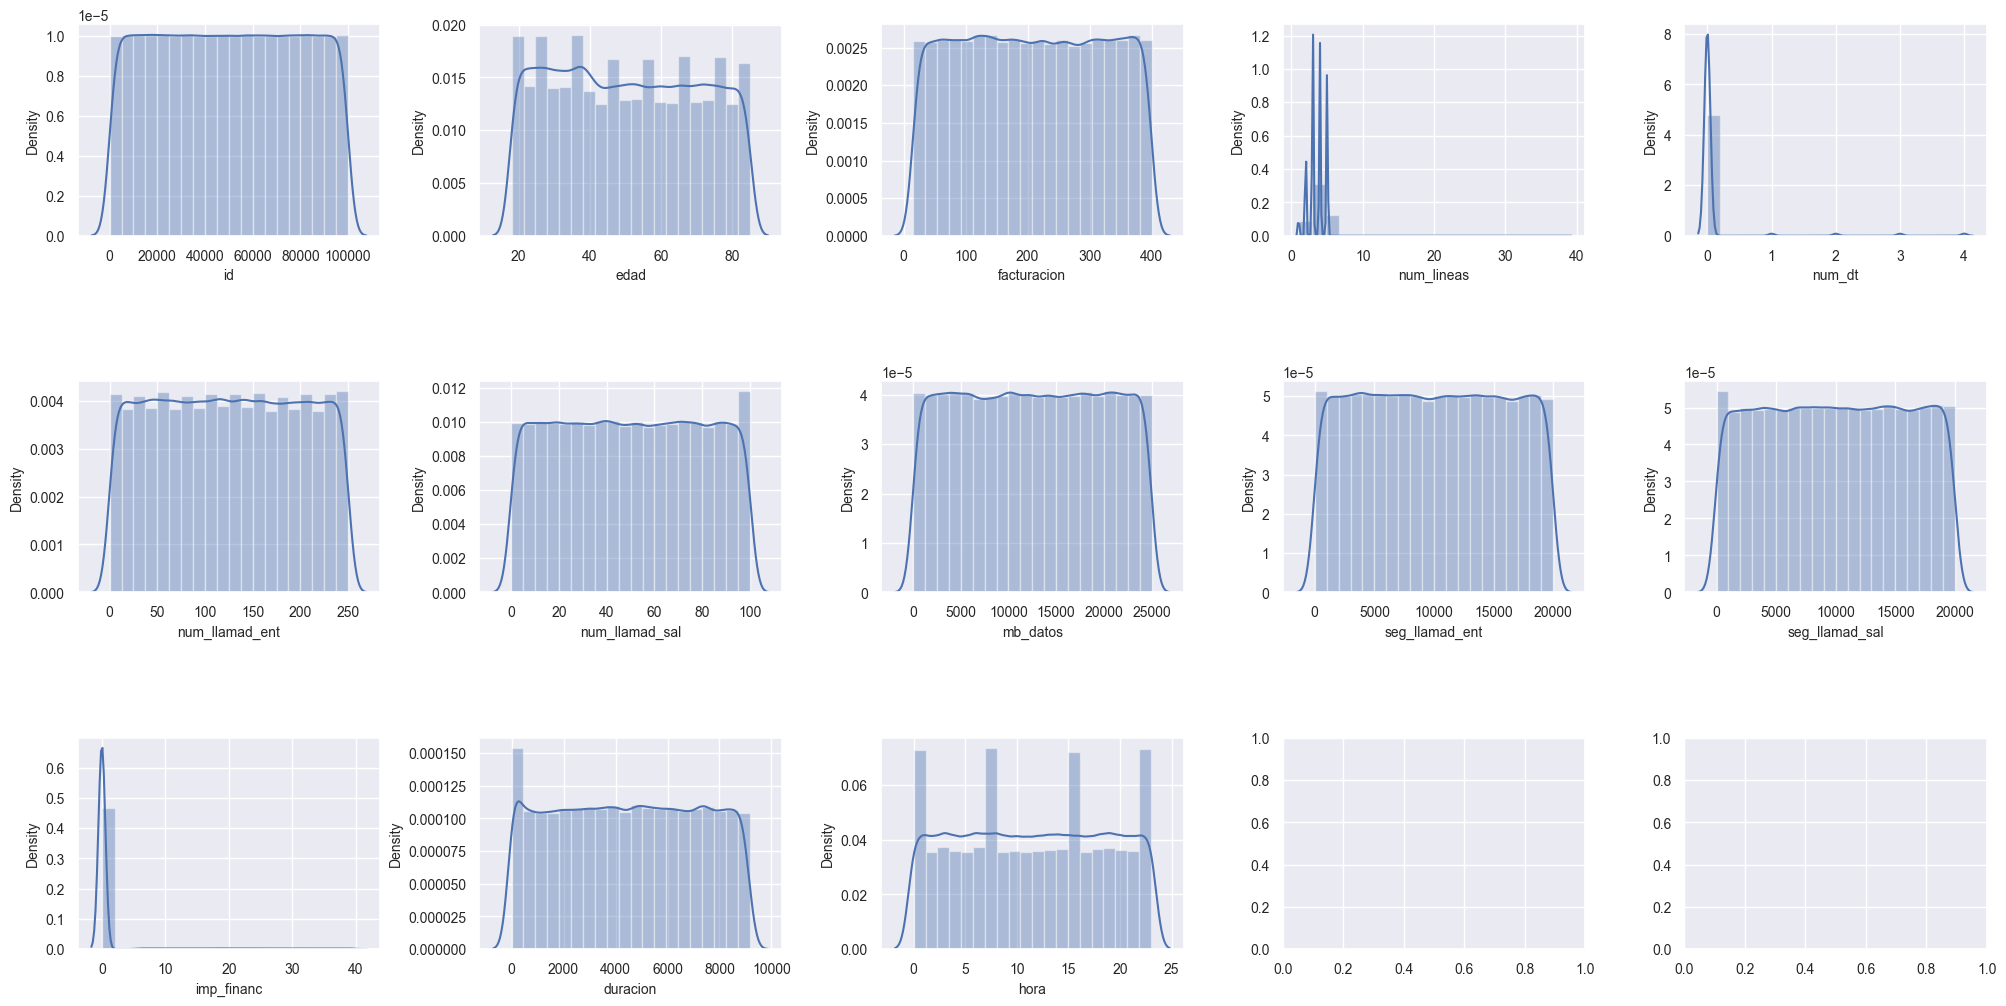

In [38]:
#Variables numéricas
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20, 10))
axs = axs.flatten() # 

index = 0
for k,v in data[num_cols].items(): 
    if  (k == 'permanencia'):
        sns.countplot(v, ax=axs[index])
    else:
        sns.distplot(v, bins=20, ax=axs[index])
    index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

ValueError: could not convert string to float: 'La Rioja'

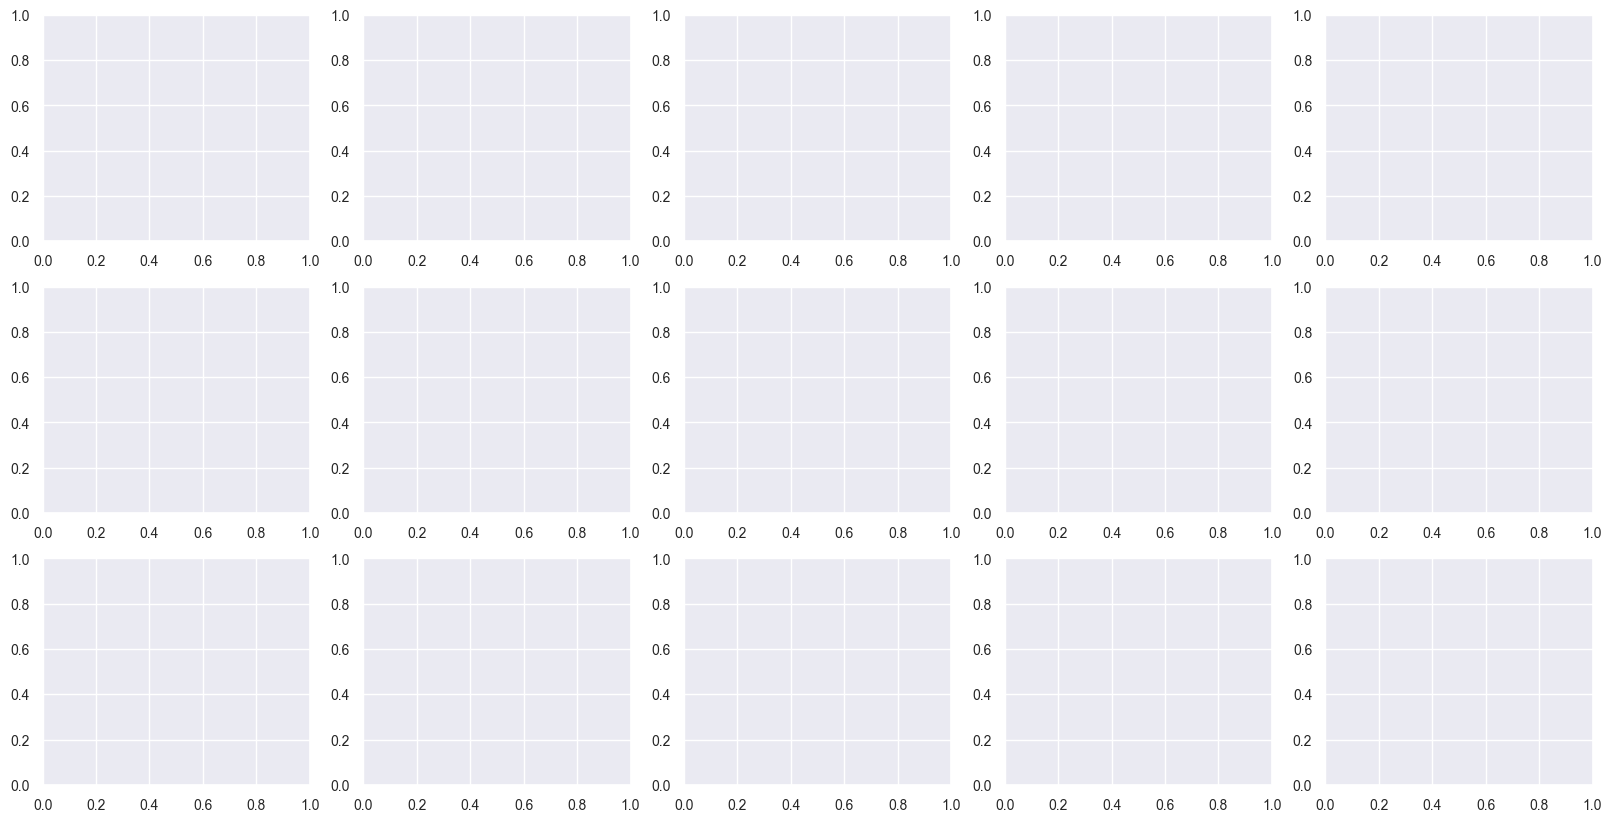

In [39]:
#Variables categóricas
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20, 10))
axs = axs.flatten() # 

index = 0
for k,v in data[cat_cols].items(): 
    sns.countplot(v, ax=axs[index])
    index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

## Transformación variables a numéricas

In [ ]:
data.dtypes

In [ ]:
variables_dummies = ['conexion','tv']
variables_binarias = ['financiacion','descuentos','incidencia']

In [ ]:
for k in variables_dummies:
    dummies = pd.get_dummies(data[k],prefix=k)
    data = pd.concat([data, dummies], axis=1)
    data.drop(k, axis=1, inplace=True)

In [ ]:
for j in variables_binarias:
    data[j] = [1 if x == 'SI' else 0 for x in data[j]]

In [ ]:
data["vel_conexion"] = data.vel_conexion.apply(lambda x: int(re.sub("MB", "", x)))
data.vel_conexion.head()

In [ ]:
## Variables nuevas

data.month.replace(('January','February','March','April','May','June','July','August','September','October','November','December'),
                      (1,2,3,4,5,6,7,8,9,10,11,12),inplace=True)

data.dia.replace(('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'),
                      (1,2,3,4,5,6,7),inplace=True)

data.hora_bin.replace(('Madrugada','Mañana','Tarde','Noche'),
                      (1,2,3,4),inplace=True)

In [ ]:
## Obtenemos la comunidad autónoma de cada provincia
url = "https://es.wikipedia.org/wiki/Provincia_(Espa%C3%B1a)"
html = requests.get(url).content
df_list = pd.read_html(html)
ccaa = df_list[1]
ccaa = ccaa[["Comunidad autónoma", "Provincia"]]
ccaa.columns =ccaa.columns.str.lower()
ccaa = ccaa.rename(columns = {'comunidad autónoma': 'com_aut'})
ccaa.provincia.replace(('Baleares'),('Islas Baleares'), inplace=True)

In [ ]:
data = pd.merge(data,ccaa,how='left',on='provincia')

In [ ]:
data

In [ ]:
data.drop('provincia', axis=1, inplace=True )

In [ ]:
len(data.com_aut.unique())

In [ ]:
data.com_aut.unique()

In [ ]:
data.com_aut.replace(('La Rioja', 'País Vasco', 'Castilla-La Mancha', 'Galicia',
                       'Cataluña', 'Andalucía', 'Comunidad Valenciana',
                       'Comunidad de Madrid', 'Islas Canarias', 'Castilla y León', 'Aragón',
                       'Navarra', 'Extremadura', 'Asturias',
                       'Islas Baleares', 'Cantabria', 'Región de Murcia'),
                        (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17),inplace=True)

In [ ]:
data.com_aut = data.com_aut.astype(int)

In [ ]:
data

In [ ]:
list_correlacion = ['edad', 'facturacion', 'num_lineas', 'num_dt', 'incidencia',
       'num_llamad_ent', 'num_llamad_sal', 'mb_datos', 'seg_llamad_ent',
       'seg_llamad_sal', 'financiacion', 'imp_financ', 'descuentos',
       'vel_conexion','duracion', 'month', 'dia', 'hora',
       'hora_bin','com_aut']

df_correlacion = data[list_correlacion]
correlation_mat = df_correlacion.corr()
sns.heatmap(correlation_mat)
plt.show()

## Vemos correlación entre las variables num_lineas y facturacion y seg_llamd_sali y financiación, aunque muy baja

In [ ]:
data.dtypes

In [ ]:
for i in list_correlacion:
    sns.boxplot(x=data[i])
    print(i)
    plt.show()
    
    
## Vemos posibles outliers en vel conexión y num_lineas. Vamos a comprobarlo con z_score    

In [ ]:
threshold = 3
z = np.abs(stats.zscore(data['vel_conexion']))
print(z)
print(np.where(z > 3))

In [ ]:
threshold = 3
z = np.abs(stats.zscore(data['num_lineas']))
print(z)
print(np.where(z > 3))

## Hay 3 valores que están fuera del rango. Podemos eliminar esas filas

data.drop([2580,8657,36987], axis=0,inplace=True)

In [ ]:
### Todos los valores cumplen con el estandar

In [ ]:
data.dtypes

In [ ]:
df_dic = pd.merge(data[data['mes']=='dic'], churn, on='id', how='left')

In [ ]:
df_dic.drop('mes', axis=1, inplace=True)
df_dic.set_index('id', inplace=True)

In [ ]:
df_dic.drop()('',axis=1)

In [ ]:
df_dic

In [ ]:
## Las variables más importantes del modelo son num_dt, incidencia, descuentos, financiacion, importe financiacion

In [ ]:
corr = abs(df_dic.corr())
corr[['churn']].sort_values(by = 'churn',ascending = False).style.background_gradient()

In [ ]:
def proporciones_final (var,target,df):

    proporcion = pd.DataFrame()
    
    proporcion['%fugas'] = df[target].groupby(df[var]).mean()*100
    proporcion['Conteo'] = df[target].groupby(df[var]).count()
    proporcion= proporcion.round(3)   
    proporcion_filtered = proporcion[(proporcion['%fugas']>0) & (proporcion['Conteo']>10)]  
        
    if len(proporcion_filtered)<100 and len(proporcion_filtered)>1:
        fig = plt.figure()
        ax = proporcion_filtered['Conteo'].plot(kind='bar',grid=True)
                
        ax2 = ax.twinx()
        ax2.plot(proporcion_filtered['%fugas'].values, linestyle='-', linewidth=2.0,color='g')
        plt.ylim(0, 100) # modificación.
        plt.tight_layout()   
        
    else:        
        proporcion_filtered.reset_index(inplace=True)
        sns.lmplot(x = var,y ='%fugas', data=proporcion_filtered,fit_reg=True,ci=None)

In [ ]:
for i in df_dic.columns:
    proporciones_final (i, 'churn', df_dic)

# Muestrear los datos, construyendo un dataset de train y test

   - Muestreo estratificado en función de la variable respuesta para que en los splits sus categorías estén bien representadas.
       - Split 80/20.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split (df_dic.drop('churn', axis=1), 
                                                     df_dic.churn,
                                                     test_size = 0.2,
                                                     random_state = 0,
                                                     stratify = df_dic.churn)

In [ ]:
modelo1 = RandomForestClassifier().fit(X_train,y_train)

In [ ]:
¿y_pred == y_test

## AUTOML COMO PRIMERA APROXIMACIÓN

In [ ]:
import pycaret
from pycaret.classification import *

Creo la variable model_setup, instacio el setup. __Parámetros__:

    - data
    - target
    - session_id: experimento

In [ ]:
dic_full

churn.churn.unique()

In [ ]:
churn

In [ ]:
dic_full['churn'] = churn.churn

In [ ]:
model_setup = setup(data=df_dic, target=churn, session_id=1)



Me dice los modelos que ha utilizado, sus métricas y el tiempo empleado

In [ ]:
best_models = compare_models()

# Modelo gbc

In [ ]:
model_gbc = create_model('gbc')

# Hiperparámetros

Imprimir todos los hiperparámetros, pero sin imputar, por defecto

In [ ]:
print(model_gbc)

# Análisis e Interpretabilidad

### Importancia de las variables = Correlación con la target

In [ ]:
plot_model(model_gbc, plot='feature')

### Curva Roc

Tanto para la clase no como para la clase sí

In [ ]:
plot_model(model_gbc, plot='auc')

### Matriz de confusión 

In [ ]:
plot_model(model_gbc, plot='confusion_matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_1))

# Modelo1

In [ ]:
modelo1 = RandomForestClassifier().fit(X_train, y_train)
y_pred = modelo1.predict(X_test)

# Modelo2 

In [ ]:
modelo2 = XGBClassifier().fit(X_train, y_train)
y_pred_2 = modelo2.predict(X_test)

# Métricas de los modelos

In [ ]:
def saca_metricas(y1, y2):
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)  

In [ ]:
saca_metricas(y_test, y_pred)

# Mejora de modelos

In [ ]:
grid_param = {
    'n_estimators': [10, 100],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'max_depth': [20,24]
}

In [ ]:
model_grid = GridSearchCV(estimator=modelo1,
                     param_grid=grid_param,
                     scoring='f1',
                     cv=5,
                     n_jobs=1)

In [ ]:
model_grid.fit(X_train, y_train)
print(model_grid.best_params_)
print(model_grid.best_score_)